<center><b><h1> Predicting Hazardous NEOs (Nearest Earth Objects) </h1></b></center>

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv("/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv")
df

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.140,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.500,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.450,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.630,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.700,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
...,...,...,...,...,...,...,...,...,...
338194,54403809,(2023 VS4),28.580,0.005112,0.011430,Earth,56646.985988,6.406548e+07,False
338195,54415298,(2023 XW5),28.690,0.004859,0.010865,Earth,21130.768947,2.948883e+07,False
338196,54454871,(2024 KJ7),21.919,0.109839,0.245607,Earth,11832.041031,5.346078e+07,False
338197,54456245,(2024 NE),23.887,0.044377,0.099229,Earth,56198.382733,5.184742e+06,False


## EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [17]:
df.describe()

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338171.000000,338171.000000,338171.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157812,0.352878,51060.662908,4.153535e+07
std,2.287225e+07,2.911216,0.313885,0.701869,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [18]:
df.isna().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

In [19]:
df.duplicated().sum()

0

In [20]:
for col in df.columns:
    print(col, ":", df[col].nunique())
    print(df[col].value_counts().nlargest(5))
    print("\n"+ "*" * 20 + "\n")

neo_id : 33514
neo_id
2277810     211
2469219     197
3678630     192
3771633     186
54353620    169
Name: count, dtype: int64

********************

name : 33514
name
277810 (2006 FV35)               211
469219 Kamo`oalewa (2016 HO3)    197
(2014 OL339)                     192
(2017 FZ2)                       186
(2023 FW13)                      169
Name: count, dtype: int64

********************

absolute_magnitude : 1778
absolute_magnitude
24.4    2208
26.1    2088
24.6    2083
25.5    2048
24.8    2038
Name: count, dtype: int64

********************

estimated_diameter_min : 1778
estimated_diameter_min
0.035039    2208
0.016016    2088
0.031956    2083
0.021113    2048
0.029144    2038
Name: count, dtype: int64

********************

estimated_diameter_max : 1778
estimated_diameter_max
0.078350    2208
0.035813    2088
0.071456    2083
0.047211    2048
0.065169    2038
Name: count, dtype: int64

********************

orbiting_body : 1
orbiting_body
Earth    338199
Name: count, dty

### check data is balanced

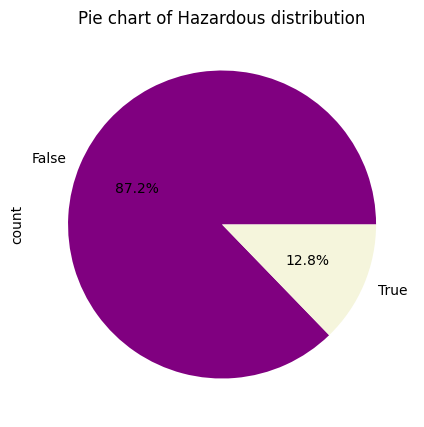

In [21]:
plt.figure(figsize=(6,5))
df['is_hazardous'].value_counts().plot(kind='pie' , autopct='%1.1f%%' , colors=['purple', 'beige'])
plt.title('Pie chart of Hazardous distribution')
plt.show()

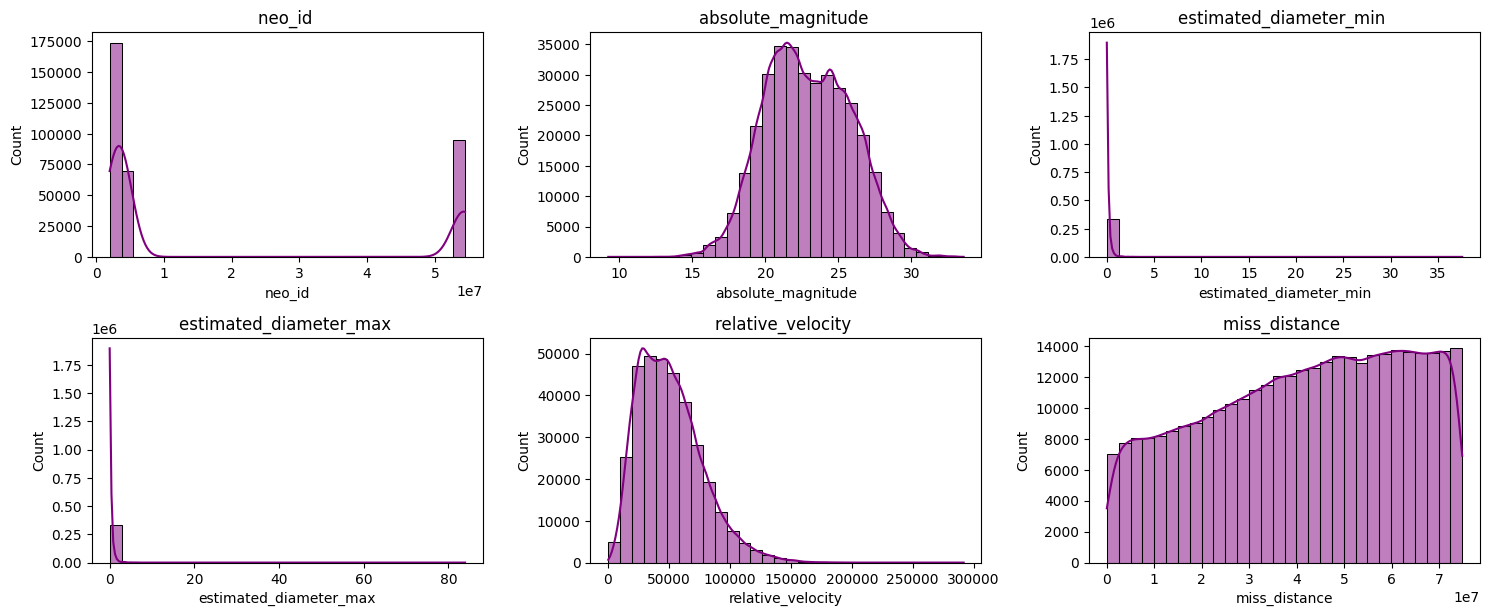

In [22]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.histplot(data=df, x=feature, bins=30, kde=True ,color="purple")
    plt.title(f'{feature} ')
plt.tight_layout()

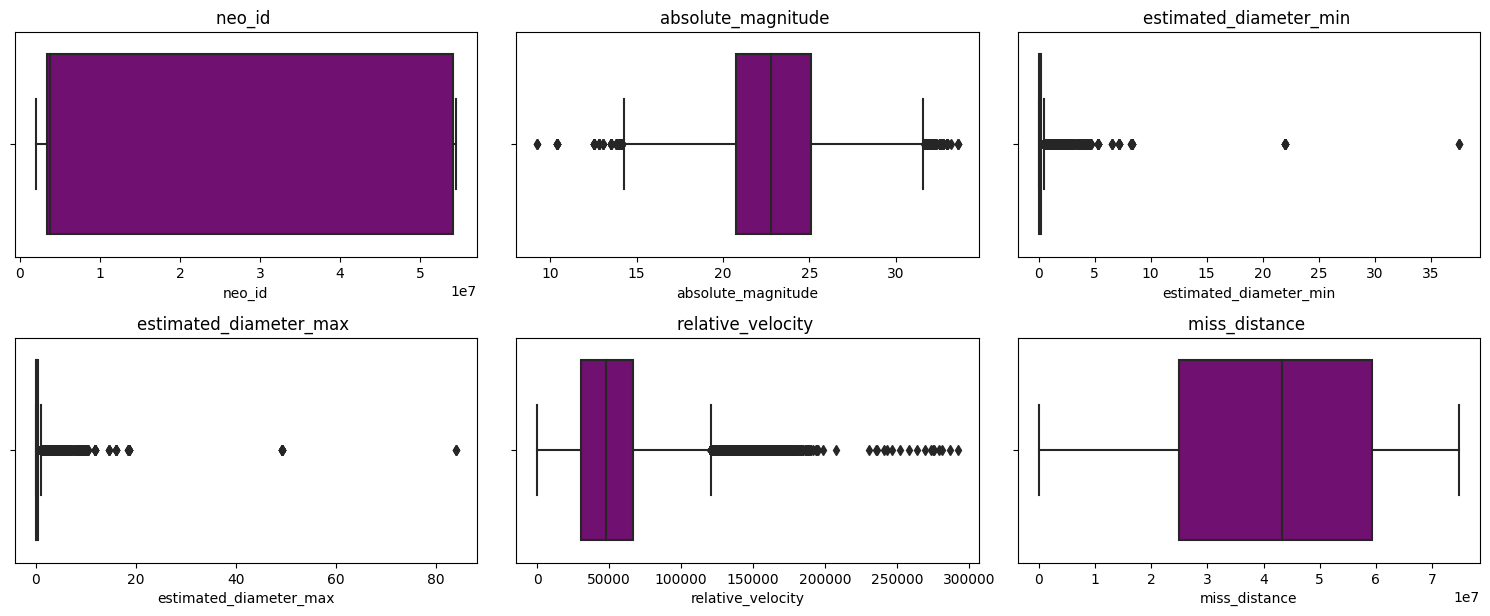

In [23]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=df, x=feature ,color="purple")
    plt.title(f'{feature} ')
plt.tight_layout()

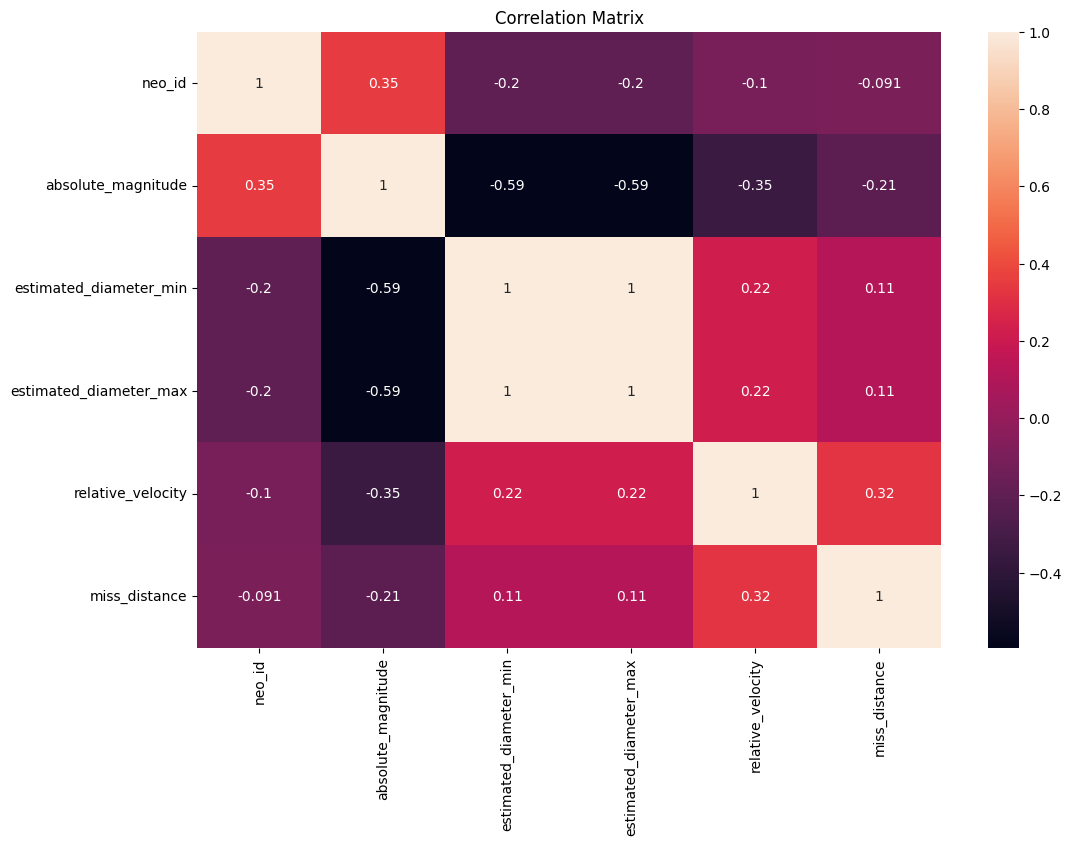

In [24]:
plt.figure(figsize=(12,8))
corr = df.select_dtypes(include='number').corr()

sns.heatmap(corr, annot=True)
plt.title("Correlation Matrix")
plt.show()

## Data cleaning
### handling missing values

In [25]:
df['absolute_magnitude'].fillna(df['absolute_magnitude'].mode()[0], inplace=True)
df['estimated_diameter_min'].fillna(df['estimated_diameter_min'].mode()[0], inplace=True)
df['estimated_diameter_max'].fillna(df['estimated_diameter_max'].mode()[0], inplace=True)

In [26]:
df.isna().sum()

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

### handling outliers

In [27]:
def remove_outliers(column):
    global df
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column] < upper_bound) & (df[column] > lower_bound)]

In [28]:
columns=['absolute_magnitude','estimated_diameter_min','estimated_diameter_max','relative_velocity']

for column in columns:
    remove_outliers(column)

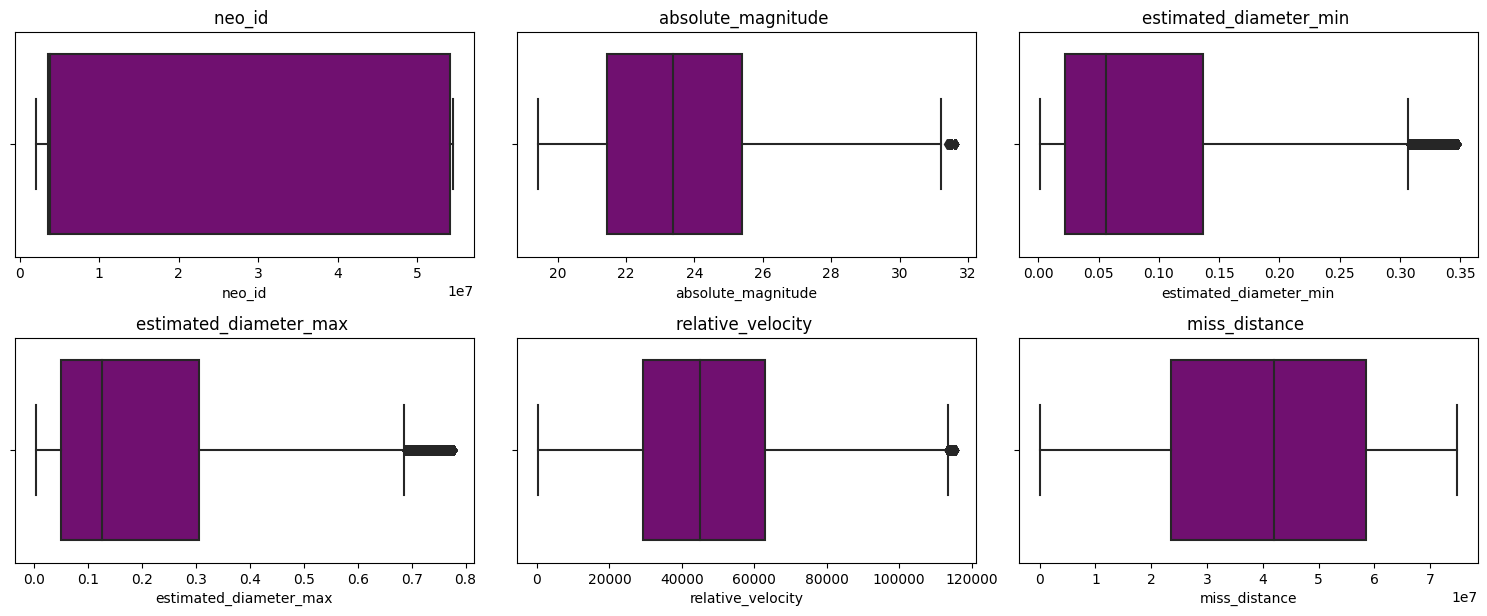

In [29]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=df, x=feature ,color="purple")
    plt.title(f'{feature} ')
plt.tight_layout()

### drop unimportant features

In [30]:
df = df.drop(columns= ['neo_id','name','orbiting_body'])

## Handling imbalance data
### using Synthetic Minority Oversampling (SMOTE)

In [31]:
x = df.drop(['is_hazardous'] ,axis=True)
y = df['is_hazardous']

In [32]:
smote = SMOTE(random_state=42)
x , y = smote.fit_resample(x,y)

In [33]:
y.value_counts()

is_hazardous
False    263607
True     263607
Name: count, dtype: int64

## Splitting dataset

In [34]:
x_train , x_test , y_train , y_test = train_test_split(x,y ,test_size=0.2 ,random_state=42)

## Models:
### 1. XGBoost

In [65]:
XGB = XGBClassifier(n_estimators=1000, learning_rate=0.1)
XGB.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [66]:
XGB.score(x_train,y_train)

0.9115942063347172

              precision    recall  f1-score   support

       False       0.95      0.85      0.90     52720
        True       0.86      0.96      0.91     52723

    accuracy                           0.90    105443
   macro avg       0.91      0.90      0.90    105443
weighted avg       0.91      0.90      0.90    105443



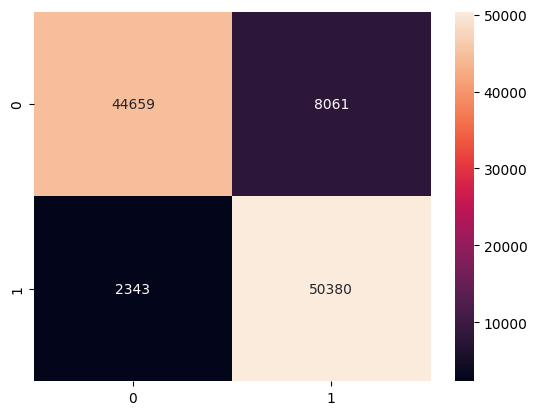

In [67]:
XGB_pred = XGB.predict(x_test)
print(classification_report(y_test, XGB_pred))

conf_matrix = metrics.confusion_matrix(y_test, XGB_pred)    
sns.heatmap(conf_matrix, annot=True ,fmt='d')
plt.show()

### 2.Light GBM

In [68]:
lgbm = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.1)
lgbm.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 210884, number of negative: 210887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 421771, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499996 -> initscore=-0.000014
[LightGBM] [Info] Start training from score -0.000014


LGBMClassifier(n_estimators=1000)

In [69]:
lgbm.score(x_train,y_train)

0.9275602163259209

              precision    recall  f1-score   support

       False       0.95      0.88      0.91     52720
        True       0.89      0.95      0.92     52723

    accuracy                           0.92    105443
   macro avg       0.92      0.92      0.92    105443
weighted avg       0.92      0.92      0.92    105443



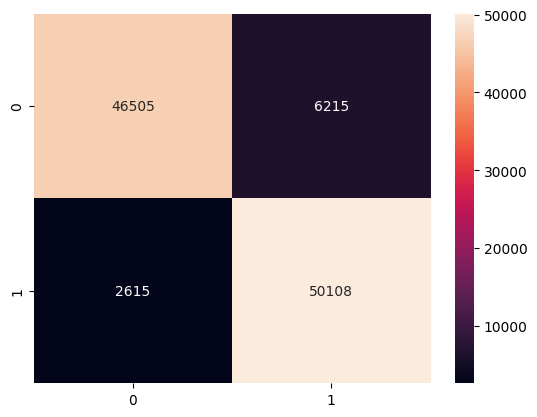

In [70]:
lgbm_pred = lgbm.predict(x_test)
print(classification_report(y_test, lgbm_pred))

conf_matrix = metrics.confusion_matrix(y_test, lgbm_pred)    
sns.heatmap(conf_matrix, annot=True ,fmt='d')
plt.show()

### 3.Random Forest

In [73]:
RF = RandomForestClassifier()
RF.fit(x_train, y_train)

RandomForestClassifier()

In [74]:
RF.score(x_train, y_train)

0.9999952580902907

              precision    recall  f1-score   support

       False       0.95      0.96      0.96     52720
        True       0.96      0.95      0.96     52723

    accuracy                           0.96    105443
   macro avg       0.96      0.96      0.96    105443
weighted avg       0.96      0.96      0.96    105443



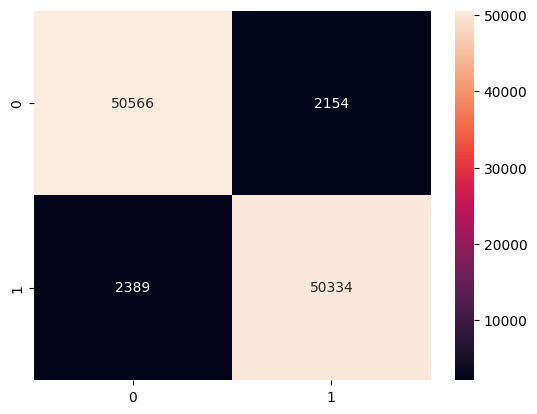

In [75]:
RF_pred = RF.predict(x_test)
print(classification_report(y_test, RF_pred))

conf_matrix = metrics.confusion_matrix(y_test, RF_pred)    
sns.heatmap(conf_matrix, annot=True ,fmt='d')
plt.show()

## Using Ensemble learning techniques:
### 1. Boosting with Random Forest 

              precision    recall  f1-score   support

       False       0.96      0.95      0.96     52720
        True       0.95      0.97      0.96     52723

    accuracy                           0.96    105443
   macro avg       0.96      0.96      0.96    105443
weighted avg       0.96      0.96      0.96    105443



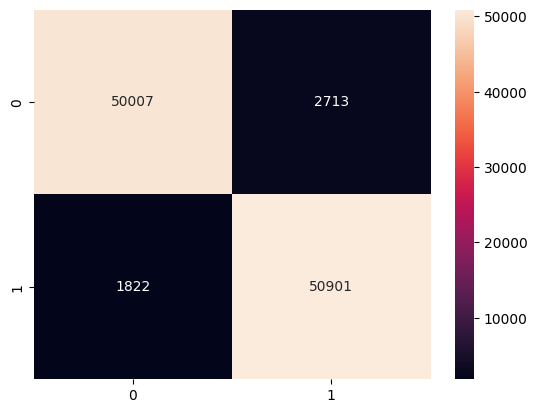

In [44]:
base_clf = RandomForestClassifier()
boost_clf = AdaBoostClassifier(base_estimator = base_clf, random_state = 42)

boost_clf.fit(x_train, y_train) 
boost_pred= boost_clf.predict(x_test)
print(classification_report(y_test,boost_pred))

conf_matrix = metrics.confusion_matrix(y_test, boost_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()

### 2. Bagging with Random Forest

              precision    recall  f1-score   support

       False       0.95      0.96      0.96     52720
        True       0.96      0.95      0.96     52723

    accuracy                           0.96    105443
   macro avg       0.96      0.96      0.96    105443
weighted avg       0.96      0.96      0.96    105443



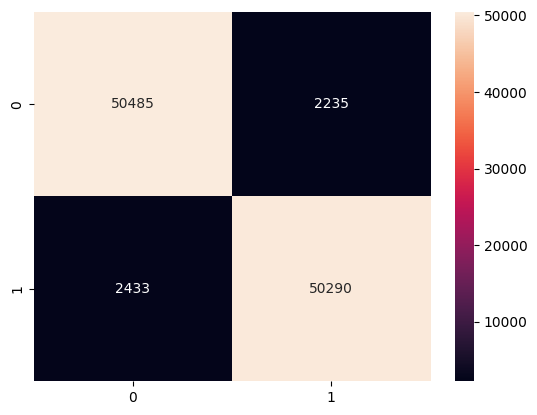

In [76]:
base_clf = RandomForestClassifier()
bag_clf = BaggingClassifier(base_estimator = base_clf, random_state = 42)
 
bag_clf.fit(x_train, y_train) 
bag_pred= bag_clf.predict(x_test)
print(classification_report(y_test,bag_pred))

conf_matrix = metrics.confusion_matrix(y_test, bag_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()